# Pre-processing of antimalarial data

This notebook contains utility functions to filter and pre-process the bioactivity data from [Antonova-Koch et al.](https://www.science.org/doi/10.1126/science.aat9446). In this study, the authors aim identify chemical leads for small molecule inhibitors of liver-stage malaria parasites by investigating the hits from a primary high-throughput screen of more than 500.000 compounds in range of confirmatory dose-response and counter-screens. 

In [1]:
import os
import random
import pandas as pd
import numpy as np
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from scipy.spatial.distance import squareform
from scipy.stats import fisher_exact

from sklearn.cluster import SpectralClustering
from sklearn.model_selection import KFold, train_test_split, GroupKFold

from rdkit import Chem
from rdkit.Chem import QED, AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity, ExplicitBitVect

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

random_seed = 1
np.random.seed(random_seed)
random.seed(random_seed)

In [2]:
df = pd.read_csv(os.path.join(os.getcwd(), 'datasets', 'antimalarial_data.txt'), sep='\t')
print(f'Loaded reconfirmation set data frame with {len(df)} entries.')
df.dtypes

Loaded reconfirmation set data frame with 9989 entries.


MMV name                                        object
SMILES                                          object
Pbluc (Single Point Inhibition, %)              object
HepG2tox (Single Point Inhibition, %)           object
IC50 PbLuc  2nd Round Average (CDD Vault)       object
IC90 PbLuc  2nd Round Average (CDD Vault)       object
 Hill slope PbLuc 2nd Round (CDD Vault)         object
R squared PbLuc 2nd Round (CDD Vault)           object
CC50 HepG2tox 2nd Round average (CDD Vault)     object
CC90 HepG2tox 2nd Round average (CDD Vault)     object
 Hill slope HepG2tox 2nd Round (CDD Vault)      object
R squared HepG2tox 2nd Round (CDD Vault)        object
IC50 FfLuc 2nd round (CDD Vault)                object
IC90 FfLuc 2nd round (CDD Vault)                object
 Hill slope FfLuc 2nd Round (CDD Vault)        float64
R squared FfLuc 2nd Round (CDD Vault)          float64
dtype: object

In [3]:
df.head(10)

,MMV name,SMILES,"Pbluc (Single Point Inhibition, %)","HepG2tox (Single Point Inhibition, %)",IC50 PbLuc 2nd Round Average (CDD Vault),IC90 PbLuc 2nd Round Average (CDD Vault),Hill slope PbLuc 2nd Round (CDD Vault),R squared PbLuc 2nd Round (CDD Vault),CC50 HepG2tox 2nd Round average (CDD Vault),CC90 HepG2tox 2nd Round average (CDD Vault),Hill slope HepG2tox 2nd Round (CDD Vault),R squared HepG2tox 2nd Round (CDD Vault),IC50 FfLuc 2nd round (CDD Vault),IC90 FfLuc 2nd round (CDD Vault),Hill slope FfLuc 2nd Round (CDD Vault),R squared FfLuc 2nd Round (CDD Vault)
0,MMV000052,CSC1=NC(=O)N=C(N1)C1=CC=C(Cl)C=C1,83.4,NaN,> 13.0,> 13.0,NaN,NaN,> 13.0,> 13.0,NaN,NaN,> 13.0,> 13.0,NaN,NaN
1,MMV000187,CC[N+]1=C(\C=C\C2=CC=C(C=C2)N(C)C)C=CC=C1,83.0,NaN,0.835,6.2,1.1,0.874,7.95,> 8.68,3.25,0.92,> 8.68,> 8.68,NaN,NaN
2,MMV001144,CCN(CC)CCNC(=O)C1=C(C)OC2=C1C(=O)C1=C(C=CC=C1)...,86.0,NaN,0.112,1.15,0.945,0.645,0.766,1.13,5.67,0.985,> 10.0,> 10.0,NaN,NaN
3,MMV001147,CC(C)CCNCC(O)CON=C1C2=CC=CC=C2C2=CC=CC=C12,83.0,NaN,> 10.0,> 10.0,NaN,NaN,> 10.0,> 10.0,NaN,NaN,> 10.0,> 10.0,NaN,NaN
4,MMV001992,CCCCC1=C(C(=O)C2=CC(I)=C(OCCN(CC)CC)C(I)=C2)C2...,86.2,NaN,> 4.84,> 4.84,1.09,0.604,> 4.84,> 4.84,NaN,NaN,> 4.84,> 4.84,1.50,0.483
5,MMV002423,CO[C@@H]1[C@@H](O)[C@H](C)O[C@@H](O[C@H]2CC[C@...,88.6,NaN,< 2.82E-03,0.138,0.244,0.495,< 2.82E-03,0.613,0.127,0.751,> 6.17,> 6.17,NaN,NaN
6,MMV002798,COC1=CC=C(CC2=C3C=C(OC)C(OC)=CC3=CC=N2)C=C1OC,84.7,NaN,> 8.78,> 8.78,NaN,NaN,> 8.78,> 8.78,NaN,NaN,> 8.78,> 8.78,NaN,NaN
7,MMV002814,C\C=C(\C(=C\C)\C1=CC=C(O)C=C1)/C1=CC=C(O)C=C1,88.6,NaN,1.24,> 12.4,0.733,0.69,> 12.4,> 12.4,1.17,0.908,1.99,10.1,1.35,0.489
8,MMV003700,CC(C)(C)C1=CC=C(C=C1)C(O)CCCN1CCC(CC1)C(O)(C1=...,83.9,NaN,6.92,> 7.00,63.6,0.484,> 7.00,> 7.00,NaN,NaN,> 7.00,> 7.00,NaN,NaN
9,MMV006169,C(NC1=NC(NC2=CC=CC=C2)=NC2=CC=CC=C12)C1=CC=CC=C1,95.8,NaN,0.476,1.76,1.68,0.822,4.76,> 10.0,1.88,0.891,> 10.0,> 10.0,NaN,NaN


In [4]:
binary_activity = dict()
activity_threshold = 1.5
inactivity_threshold = 3

# select measurements with > qualifier, all of them are over 1.5 uM
for i in df[df["IC50 PbLuc  2nd Round Average (CDD Vault)"].astype(str).str.contains(">", regex=False)].index:
    binary_activity[i] = False
    
# select measurements with < qualifier, all of them are under 1.5 uM
for i in df[df["IC50 PbLuc  2nd Round Average (CDD Vault)"].astype(str).str.contains("<", regex=False)].index:
    binary_activity[i] = True

ic50_values = df.loc[~df['IC50 PbLuc  2nd Round Average (CDD Vault)'].str.contains('[<>]'), ['IC50 PbLuc  2nd Round Average (CDD Vault)']].astype(float)

for i in ic50_values[ic50_values["IC50 PbLuc  2nd Round Average (CDD Vault)"] <= activity_threshold].index:
    binary_activity[i] = True

for i in ic50_values[ic50_values["IC50 PbLuc  2nd Round Average (CDD Vault)"] >= inactivity_threshold].index:
    binary_activity[i] = False
    
df["activity"] = pd.Series(binary_activity)
df["activity"].value_counts(normalize=True)

#f, ax = plt.subplots(figsize=(10, 4))
#sns.histplot(ic50_values, bins=50, element="step")
#plt.axvline(activity_threshold, color="green")
#plt.axvline(inactivity_threshold, color="red")
#plt.xlabel("PbLuc IC50 [uM]")

#sns.despine()
#plt.tight_layout()
#plt.legend([],[], frameon=False)

#plt.savefig('antimalarial_ic50.png')  

activity
False    0.89086
True     0.10914
Name: proportion, dtype: float64

In [5]:
# filter out all cytotoxic compounds by using the thresholds
# HepG2tox CC50 < 2X Pbluc IC50 or HepG2tox CC50 < maximum tested concentration

# filter out entries with a < qualifier, entries with a > qualifier 
# indicate weak cytotoxicity and can be ignored for the filtering
print(f"Filtering out {df['CC50 HepG2tox 2nd Round average (CDD Vault)'].str.contains('<').sum()} strongly hepatotoxic compounds with qualified values.")
df = df[~df['CC50 HepG2tox 2nd Round average (CDD Vault)'].str.contains('<')]
heptox = df[~df['CC50 HepG2tox 2nd Round average (CDD Vault)'].str.contains('>')]

heptox['CC50 HepG2tox 2nd Round average (CDD Vault)'] = heptox['CC50 HepG2tox 2nd Round average (CDD Vault)'].astype(float)
heptox = heptox[heptox['CC50 HepG2tox 2nd Round average (CDD Vault)'] < 10]

# manual inspection of qualified Pbluc inhibition readouts yields no examples to be removed
heptox = heptox[~heptox["IC50 PbLuc  2nd Round Average (CDD Vault)"].astype(str).str.contains("[<>]")]
heptox = heptox[heptox['CC50 HepG2tox 2nd Round average (CDD Vault)'] < 2 * heptox["IC50 PbLuc  2nd Round Average (CDD Vault)"].astype(float)]

heptox["activity"].value_counts(dropna=False)

Filtering out 1 strongly hepatotoxic compounds with qualified values.


/tmp/ipykernel_4019800/688803165.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heptox['CC50 HepG2tox 2nd Round average (CDD Vault)'] = heptox['CC50 HepG2tox 2nd Round average (CDD Vault)'].astype(float)


activity
False    538
NaN      117
True     109
Name: count, dtype: int64

In [6]:
# filter out all readout-interfering compounds by using the thresholds
# Ffluc IC50 < 2X PblucIC50 or Ffluc IC50 < maximum tested concentration

# compounds with very strong (< qualifier) Fluc binding are filtered out,
# compounds with weak (> qualifier) Fluc interference are kept
print(f"Filtering out {df['IC50 FfLuc 2nd round (CDD Vault)'].str.contains('<').sum()} interfering compounds with qualified values.")
df = df[~df['IC50 FfLuc 2nd round (CDD Vault)'].str.contains('<')]
fluc = df[~df['IC50 FfLuc 2nd round (CDD Vault)'].str.contains('>')]

fluc['IC50 FfLuc 2nd round (CDD Vault)'] = fluc['IC50 FfLuc 2nd round (CDD Vault)'].astype(float)
fluc = fluc[fluc['IC50 FfLuc 2nd round (CDD Vault)'] <= 10]

# manual inspection of qualified Pbluc inhibition readouts yields no examples to be removed
fluc = fluc[~fluc["IC50 PbLuc  2nd Round Average (CDD Vault)"].astype(str).str.contains("[<>]")]
fluc = fluc[fluc['IC50 FfLuc 2nd round (CDD Vault)'] < 2 * fluc["IC50 PbLuc  2nd Round Average (CDD Vault)"].astype(float)]

fluc["activity"].value_counts(dropna=False)

Filtering out 26 interfering compounds with qualified values.


/tmp/ipykernel_4019800/2022255157.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fluc['IC50 FfLuc 2nd round (CDD Vault)'] = fluc['IC50 FfLuc 2nd round (CDD Vault)'].astype(float)


activity
False    379
True      35
NaN       32
Name: count, dtype: int64

In [7]:
# filter out compounds identified as cytotoxic or assay interfering
df = df.drop(index=heptox.index.union(fluc.index).intersection(df.index))
print(f'Filtering out {len(heptox)} cytotoxic and {len(fluc)} luciferase-interfering compounds, with {len(heptox.index.intersection(fluc.index)),} compounds flgged in both.')

Filtering out 764 cytotoxic and 446 luciferase-interfering compounds, with (49,) compounds flgged in both.


In [8]:
# drop unnessecary columns and compounds for which binarization of labels resulted in NaN
df = df[["SMILES", "activity", "IC50 PbLuc  2nd Round Average (CDD Vault)"]].rename(columns={"IC50 PbLuc  2nd Round Average (CDD Vault)": "reg_readout"})
df = df.dropna(subset=["activity"])

# Molecule cleaning and featurization



In [9]:
%%capture
# read in molecules and filter out any drug-unlike compounds

fragment_chooser = rdMolStandardize.LargestFragmentChooser()
uncharger = rdMolStandardize.Uncharger()

# define allowed atom types
allowed_elements = {
    1, # H
    6, # C
    7, # N
    8, # O
    16, # S
    9, # F
    17, # Cl
    35, # Br
    53, # I
}

def convert_and_clean(row):
    
    # convert SMILES string to rdkit Mol object and 
    mol = Chem.MolFromSmiles(row["SMILES"])

    # check if molecule contains invalid atom types
    if mol is None or {atom.GetAtomicNum() for atom in mol.GetAtoms()} - allowed_elements:
        return None
    
    # if molecule only contains allowed atom types,
    # perform additional sanitisation steps
    else:
        mol = rdMolStandardize.Cleanup(mol)
        mol = fragment_chooser.choose(mol)
        mol = uncharger.uncharge(mol)
        return {"mol": mol, "smiles": Chem.MolToSmiles(mol), "label": row["activity"]}

df = df.apply(convert_and_clean, axis=1)

In [10]:
print(f"Dropping {df.isna().sum()} molecules with invalid element types.")
df = df.dropna()

df = df.apply(pd.Series)
assert df["mol"].isna().sum() == 0, "Could not parse some molecules."
assert df["smiles"].value_counts().max() == 1, "Found duplicate molecules."

df['label'] = df['label'].astype(bool)

df['scaffold'] = df['mol'].apply(lambda mol: Chem.MolToSmiles(MurckoScaffold.MakeScaffoldGeneric(MurckoScaffold.GetScaffoldForMol(mol))))
assert df["scaffold"].isna().sum() == 0, "Error in scaffold generation."
print(f'Number of compounds without Bemis-Murcko scaffold: {(df["scaffold"] == "").sum()}')

# derive molecular properties and also add number of heavy atoms
props = df.apply(lambda x: QED.properties(x['mol'])._asdict(), axis=1, result_type='expand')
df = df.join(props)
mol_props = props.columns.to_list()
mol_props.remove('ALERTS')
df["num_atoms"] = df["mol"].apply(lambda x: x.GetNumHeavyAtoms())
mol_props.append("num_atoms")

# reset index
df = df.reset_index(drop=True)
assert df.isna().sum().sum() == 0
print(f"Remaining number of molecules: {len(df)}")

Dropping 0 molecules with invalid element types.
Number of compounds without Bemis-Murcko scaffold: 4
Remaining number of molecules: 8150


In [11]:
def get_fingerprints(mol, rad=2):
    """
    Generate extended connectivity and rdkit bit vector fingerprints.
    """
    
    fps = dict()
    fps['ec_bit_fp'] = AllChem.GetMorganFingerprintAsBitVect(mol, rad, nBits=2048)
    fps['rdkit_bit_fp'] = Chem.RDKFingerprint(mol, maxPath=rad * 2)

    return fps

# generate extended connectivity and rdkit bit vector fingerprints 
df = df.join(df.apply(lambda x: get_fingerprints(x['mol']), result_type='expand', axis=1))

# convert bit vectors to scipy sparse arrays
for col in tqdm(["ec_bit_fp", "rdkit_bit_fp"]):
    fp_mat = sp.vstack(df[col].apply(lambda x: sp.csr_matrix(np.array(x))))
    df[col] = [fp_mat[i] for i in range(fp_mat.shape[0])]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:22<00:00, 11.44s/it]


In [12]:
# apply variance thresholding to discard uninformative bits and save the
# informative columns to use them to match samples from the context point distribution
variance_treshold = 0
info_cols = dict()

for col in ["ec_bit_fp", "rdkit_bit_fp"]:
    variances = sp.vstack(df[col].to_list()).A.var(0)
    informative_cols = np.where(variances > 0)[0]
    print(f"Number of informative bits for {col}: {len(informative_cols)}/{df[col].iloc[0].shape[1]}")
    info_cols[col] = informative_cols
    df[col] = df[col].apply(lambda x: x[:, informative_cols])
    
np.savez(os.path.join("datasets", "info_cols.npz"), **info_cols)

Number of informative bits for ec_bit_fp: 2048/2048
Number of informative bits for rdkit_bit_fp: 2042/2048


In [13]:
# precompute the pairwise distances between all molecules for the rdkit and ecfp bit vectors

def precompute_kernel(bit_vecs_sp):
    
    # convert scipy sparse fingerprints back to rdkit bit vectors
    bit_vecs_rdkit = []
    for bit_vec in bit_vecs_sp:
        bv = ExplicitBitVect(bit_vec.shape[1])
        bv.SetBitsFromList(bit_vec.indices.tolist())
        bit_vecs_rdkit.append(bv)
    
    # generate pair-wise distances and similarities
    dists = []
    for i in tqdm(range(len(bit_vecs_rdkit))):
        dists.extend(
            BulkTanimotoSimilarity(
                bit_vecs_rdkit[i],
                bit_vecs_rdkit[(i+1):],
                returnDistance=True
            )
        )
    dists = squareform(dists)
    return dists

precomputed_kernels = {fp: precompute_kernel(df[fp]) for fp in ["ec_bit_fp", "rdkit_bit_fp"]}

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8150/8150 [00:05<00:00, 1577.40it/s]


# Exploratory data analysis

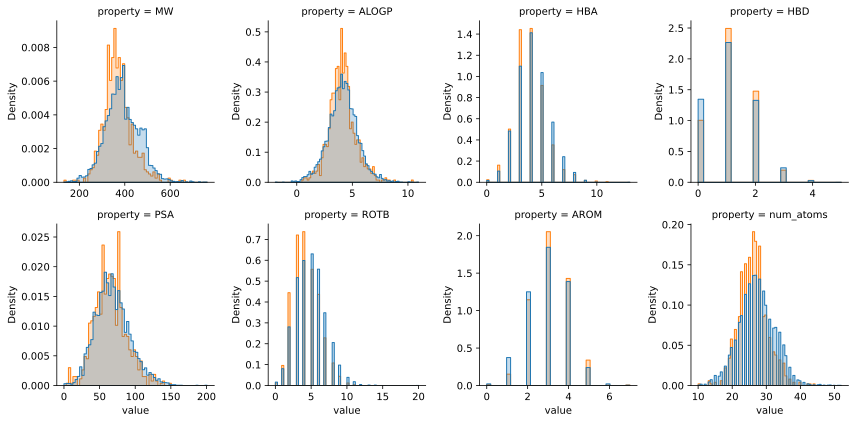

In [14]:
# check how well labels correlate with different molecualr properties
plot_df = pd.melt(
    frame=df,
    id_vars=['label'],
    value_vars=mol_props,
    var_name='property'
)
g = sns.FacetGrid(data=plot_df, col='property', sharex=False, sharey=False, col_wrap=4)
g.map_dataframe(sns.histplot, x='value', common_norm=False, hue='label', common_bins=True, element='step', stat='density')

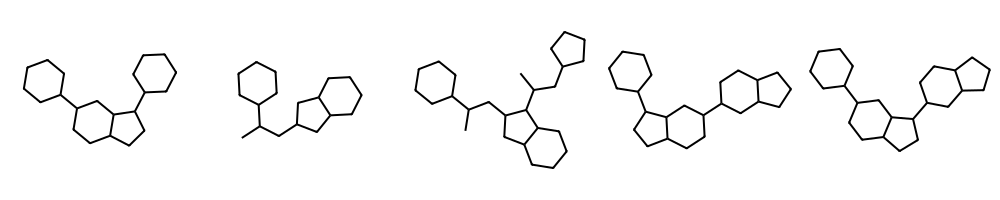

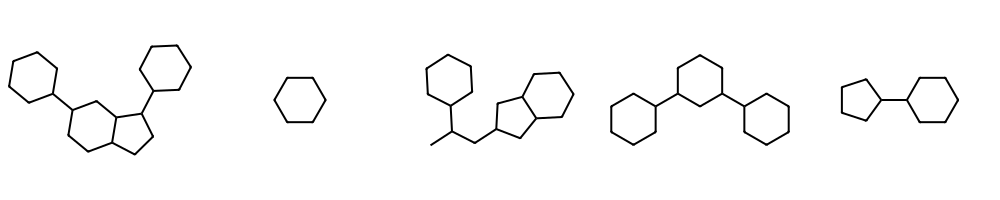

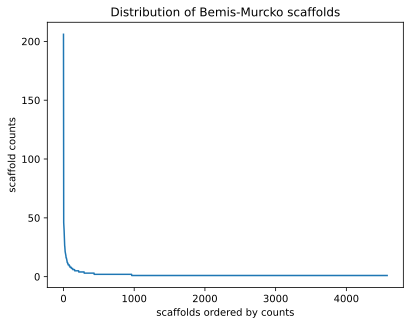

In [15]:
# look at the most common scaffolds and the scaffold frequencies

scaffold_counts = df['scaffold'].value_counts().reset_index(drop=True).rename('scaffold counts')
sns.lineplot(x=scaffold_counts.index, y=scaffold_counts)
plt.xlabel('scaffolds ordered by counts')
plt.title('Distribution of Bemis-Murcko scaffolds')

# display the 5 most common scaffolds for active and inactive molecules
display(MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold in df.loc[df["label"], 'scaffold'].value_counts().head(5).index], molsPerRow=5))
MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold in df.loc[~df["label"], 'scaffold'].value_counts().head(5).index], molsPerRow=5)

In [16]:
# look at the correlation of Tanimoto distances across featurizations
dists_df = pd.DataFrame({k: squareform(v) for k, v in precomputed_kernels.items()}).sample(1000000)
dists_df.corr('spearman')

,ec_bit_fp,rdkit_bit_fp
ec_bit_fp,1.000000,0.531149
rdkit_bit_fp,0.531149,1.000000


# Train-test splits

## Spectral splits

In [17]:
# perform spectral clustering for rdkit bit vector fingerprints using precomputed Tanimoto distance metric
# denoting the training set with True and test set with False

clusters = pd.Series(
    SpectralClustering(
        n_clusters=2,
        affinity='precomputed',
        random_state=1,
        assign_labels='kmeans'
    ).fit_predict(1 - precomputed_kernels['rdkit_bit_fp'])
) 
display(clusters.value_counts(dropna=False, normalize=True))
df['rdkit_bit_fp_spectral_split'] = clusters.replace({1: True, 0: False}).to_numpy()

# additionally split training set into four clusters,
# using one as a validation set and the other three as
# domain indicators for domain adaptation approaches

train_indices = df[df["rdkit_bit_fp_spectral_split"]].index
cl = pd.Series(SpectralClustering(
            n_clusters=4,
            affinity='precomputed',
            random_state=1,
            assign_labels='discretize'
        ).fit_predict((1 - precomputed_kernels['rdkit_bit_fp'])[np.ix_(train_indices, train_indices)]))
cl.index = train_indices
df[f"rdkit_bit_fp_spectral_split_cv"] = cl
df[f"rdkit_bit_fp_spectral_split_cv"].value_counts(dropna=False, normalize=False).sort_index()

1    0.647362
0    0.352638
Name: proportion, dtype: float64

rdkit_bit_fp_spectral_split_cv
0.0    1237
1.0    1537
2.0     844
3.0    1658
NaN    2874
Name: count, dtype: int64

In [18]:
# repeat the same approach for ecfp fingerprints

clusters = pd.Series(
    SpectralClustering(
        n_clusters=2,
        affinity='precomputed',
        random_state=1,
        assign_labels='kmeans',
    ).fit_predict(1 - precomputed_kernels['ec_bit_fp'])
) 
display(clusters.value_counts(dropna=False, normalize=True))
df['ec_bit_fp_spectral_split'] = clusters.replace({0: True, 1: False}).to_numpy()

# additionally split training set into four clusters,
# using one as a validation set and the other three as
# domain indicators for domain adaptation approaches

train_indices = df[df["ec_bit_fp_spectral_split"]].index
cl = pd.Series(SpectralClustering(
            n_clusters=4,
            affinity='precomputed',
            random_state=1,
            assign_labels='discretize'
        ).fit_predict((1 - precomputed_kernels['ec_bit_fp'])[np.ix_(train_indices, train_indices)]))
cl.index = train_indices
df[f"ec_bit_fp_spectral_split_cv"] = cl
df[f"ec_bit_fp_spectral_split_cv"].value_counts(dropna=False, normalize=False).sort_index()

0    0.796319
1    0.203681
Name: proportion, dtype: float64

ec_bit_fp_spectral_split_cv
0.0    1711
1.0    1336
2.0    1644
3.0    1799
NaN    1660
Name: count, dtype: int64

## Molecular weight splits

In [19]:
# order molecules by molecular weight and split off the same proportion as used for the ECFP test set
mw_indexes = np.argsort(df['MW'].to_numpy())[:df['ec_bit_fp_spectral_split'].sum()]
mw_split = np.zeros(len(df), dtype=bool)
mw_split[mw_indexes] = True
df['mw_split'] = mw_split

# repeat this procedure four times to get four additional partitions,
# using one as a validation set and the other three as
# domain indicators for domain adaptation approaches

mw_cvs = pd.DataFrame(
    [
        {"index": j, "mw_split_cv": i} for i, (_, te) in enumerate(
            KFold(n_splits=4).split(mw_indexes)) for j in mw_indexes[te]
    ]
).set_index("index", drop=True)
df["mw_split_cv"] = mw_cvs["mw_split_cv"]
assert df.loc[df["mw_split"], "mw_split_cv"].isna().sum() == 0
df["mw_split_cv"].value_counts(dropna=False).sort_index()

mw_split_cv
0.0    1623
1.0    1623
2.0    1622
3.0    1622
NaN    1660
Name: count, dtype: int64

## Scaffold splits

In [20]:
# split data by scaffolds, use 5 folds to approximately
# match the test set size of the other splits
gss = GroupKFold(n_splits=5)
scaffold_split_indices, _ = next(gss.split(X=np.arange(len(df)), y=df['label'].to_numpy(), groups=df['scaffold'].to_numpy()))
scaffold_split = np.zeros(len(df), dtype=bool)
scaffold_split[scaffold_split_indices] = True
df['scaffold_split'] = scaffold_split
assert not len(set(df.loc[df['scaffold_split'], 'scaffold']) & set(df.loc[~df['scaffold_split'], 'scaffold'])), "Scaffold overlap."

# repeat this procedure four times to get four additional partitions,
# using one as a validation set and the other three as
# domain indicators for domain adaptation approaches

scaffold_cvs = pd.DataFrame([
    {"index": j, "scaffold_split_cv": i} for i, (_, ts) in enumerate(
        GroupKFold(n_splits=4).split(
            X=scaffold_split_indices, groups=df.loc[df['scaffold_split'], "scaffold"])) for j in scaffold_split_indices[ts]
]).set_index("index", drop=True)
df["scaffold_split_cv"] = scaffold_cvs["scaffold_split_cv"]
assert df.loc[df["scaffold_split"], "scaffold_split_cv"].isna().sum() == 0
df["scaffold_split_cv"].value_counts(dropna=False).sort_index()

scaffold_split_cv
0.0    1630
1.0    1630
2.0    1630
3.0    1630
NaN    1630
Name: count, dtype: int64

## Random Splits

In [21]:
# split data randomly
random_indices = train_test_split(np.arange(len(df)), train_size=df['ec_bit_fp_spectral_split'].mean(), random_state=random_seed, shuffle=True, stratify=df['label'])[0]
random_split = np.zeros(len(df), dtype=bool)
random_split[random_indices] = True
df['random_split'] = random_split

# presplit training set into 5 cross-validation folds
# usig random split
rand_cvs = pd.DataFrame([
    {"index": j, "random_split_cv": i} for i, (_, ts) in enumerate(
        KFold(n_splits=4, shuffle=True, random_state=random_seed).split(
            random_indices)) for j in random_indices[ts]
]).set_index("index", drop=True)
df["random_split_cv"] = rand_cvs["random_split_cv"]
assert df.loc[df["random_split"], "random_split_cv"].isna().sum() == 0
df["random_split_cv"].value_counts(dropna=False).sort_index()

random_split_cv
0.0    1623
1.0    1623
2.0    1622
3.0    1622
NaN    1660
Name: count, dtype: int64

# Analyze splits

In [22]:
split_cols = [
    'ec_bit_fp_spectral_split', 'rdkit_bit_fp_spectral_split', 'mw_split', 'scaffold_split', 'random_split'
]
assert set(split_cols).issubset(set(df.columns))

In [23]:
# display sizes and positive label ratios in each split
for split_col in split_cols:
    print(f"{split_col}: train plr - {df.loc[df[split_col], 'label'].mean():.2f}, test plr - {df.loc[~df[split_col], 'label'].mean():.2f}")
    print(df[split_col].value_counts(normalize=True))

ec_bit_fp_spectral_split: train plr - 0.09, test plr - 0.15
ec_bit_fp_spectral_split
True     0.796319
False    0.203681
Name: proportion, dtype: float64
rdkit_bit_fp_spectral_split: train plr - 0.09, test plr - 0.12
rdkit_bit_fp_spectral_split
True     0.647362
False    0.352638
Name: proportion, dtype: float64
mw_split: train plr - 0.12, test plr - 0.05
mw_split
True     0.796319
False    0.203681
Name: proportion, dtype: float64
scaffold_split: train plr - 0.10, test plr - 0.12
scaffold_split
True     0.8
False    0.2
Name: proportion, dtype: float64
random_split: train plr - 0.10, test plr - 0.10
random_split
True     0.796319
False    0.203681
Name: proportion, dtype: float64


## Calculate covariate shift

In [24]:
def kernel_2samp_test(train_idx, sim_mat, split, kernel, verbose=False):
    """
    Implements the unbiased estimator of the maximum mean discrepancy statistic for a training index splitting a given kenrel similarity matrix.
    """
    train_mean = (sim_mat[np.ix_(train_idx, train_idx)].sum() - train_idx.sum()) / (train_idx.sum() * (train_idx.sum() - 1))
    test_mean = (sim_mat[np.ix_(~train_idx, ~train_idx)].sum() - (~train_idx).sum()) / ((~train_idx).sum() * ((~train_idx).sum() - 1))
    train_test_mean = sim_mat[np.ix_(train_idx, ~train_idx)].mean()
    if verbose:
        print(f"train mean - {train_mean:.3f}, test mean - {test_mean:.3f}, train-test mean - {train_test_mean:.3f}")
        
    mmd_squared = train_mean + test_mean - 2 * train_test_mean
    if not np.all(mmd_squared > 0):
        print(f"Not all values positive for {split} split with {kernel} featurization")
    return np.sqrt(mmd_squared)

cov_shift_results = []
for split_col in split_cols:
    for kernel in precomputed_kernels:
        # for spectral splits, only calculate MMD wrt fingerprint that was used for deriving clsuters
        if "spectral" in split_col and not kernel in split_col:
            continue
        cov_shift_results.append({
            "2-sample test statistic": kernel_2samp_test(df[split_col].to_numpy(), 1 - precomputed_kernels[kernel], split=split_col, kernel=kernel),
            "split": split_col,
            "kernel": kernel,
        })

# for the random split (with no covariate shift), evaluating the MMD statistic 
# amounts to np.sqrt(0) (or slightly negative values), which produces NaNs 
cov_shift_results = pd.DataFrame(cov_shift_results).fillna(0)
cov_shift_results

Not all values positive for random_split split with ec_bit_fp featurization


/tmp/ipykernel_4019800/3117436842.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(mmd_squared)


Not all values positive for random_split split with rdkit_bit_fp featurization


,2-sample test statistic,split,kernel
0,0.244681,ec_bit_fp_spectral_split,ec_bit_fp
1,0.325742,rdkit_bit_fp_spectral_split,rdkit_bit_fp
2,0.094304,mw_split,ec_bit_fp
3,0.134332,mw_split,rdkit_bit_fp
4,0.067999,scaffold_split,ec_bit_fp
5,0.080337,scaffold_split,rdkit_bit_fp
6,0.000000,random_split,ec_bit_fp
7,0.000000,random_split,rdkit_bit_fp


## Quantify label shift with Fisher's exact test

In [25]:
fishers_test = []

for split_col in split_cols:

    train_set_pos = df[df[split_col] & df['label']].index
    train_set_neg = df[df[split_col] & ~df['label']].index
    test_set_pos = df[~df[split_col] & df['label']].index
    test_set_neg = df[~df[split_col] & ~df['label']].index
    
    contingency_mat = np.array([[len(train_set_neg), len(train_set_pos)],[len(test_set_neg), len(test_set_pos)]])
    fishers_test_results = fisher_exact(contingency_mat)
    fishers_test.append({"split": split_col, "fishers_exact_statistic": fishers_test_results[0], "fishers_exact_pvalue": fishers_test_results[1]})

fishers_test = pd.DataFrame(fishers_test)
fishers_test["fishers_exact_pvalue"] = - fishers_test["fishers_exact_pvalue"].apply(np.log10)
fishers_test

,split,fishers_exact_statistic,fishers_exact_pvalue
0,ec_bit_fp_spectral_split,1.766689,11.085437
1,rdkit_bit_fp_spectral_split,1.364215,4.530983
2,mw_split,0.404479,16.539930
3,scaffold_split,1.200579,1.430804
4,random_split,1.000607,-0.000000


## Visualize covariate and label shift

In [26]:
data_shift_df = cov_shift_results.merge(fishers_test, on="split")
data_shift_df["split"] = data_shift_df["split"].replace({"ec_bit_fp_spectral_split": "spectral_split", "rdkit_bit_fp_spectral_split": "spectral_split"})
data_shift_df

,2-sample test statistic,split,kernel,fishers_exact_statistic,fishers_exact_pvalue
0,0.244681,spectral_split,ec_bit_fp,1.766689,11.085437
1,0.325742,spectral_split,rdkit_bit_fp,1.364215,4.530983
2,0.094304,mw_split,ec_bit_fp,0.404479,16.539930
3,0.134332,mw_split,rdkit_bit_fp,0.404479,16.539930
4,0.067999,scaffold_split,ec_bit_fp,1.200579,1.430804
5,0.080337,scaffold_split,rdkit_bit_fp,1.200579,1.430804
6,0.000000,random_split,ec_bit_fp,1.000607,-0.000000
7,0.000000,random_split,rdkit_bit_fp,1.000607,-0.000000


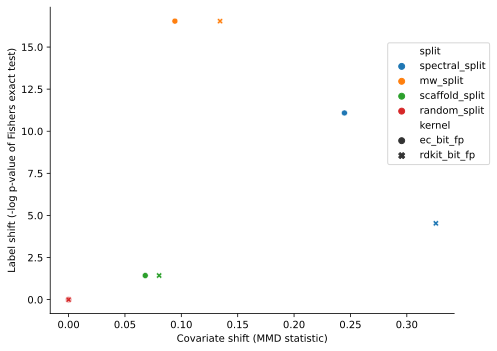

In [27]:
fig, axs = plt.subplots(figsize=(7,5))
g = sns.scatterplot(
    data=data_shift_df,
    x="2-sample test statistic",
    y="fishers_exact_pvalue",
    hue="split",
    style="kernel"
)
sns.despine()
axs.legend(bbox_to_anchor=(1.1, 0.9))
plt.xlabel("Covariate shift (MMD statistic)")
plt.ylabel("Label shift (-log p-value of Fishers exact test)")
plt.tight_layout()
plt.savefig("data_shift.png")

# Save processed data for model training and evaluation

In [28]:
df.drop(columns=["mol"]).to_pickle(os.path.join(os.getcwd(), 'datasets', 'antimalarial_data_processed.pkl'), protocol=4)